# A/B test analysis

## Description of the project

As part of the project, it is planned to analyze the results of the A / B test and decide to stop or continue the test.

## A/B test analysis

### Data preprocessing

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

c:\Users\AD\anaconda3\envs\practicum\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#load dataset
orders = pd.read_csv('./datasets/orders.csv', sep=',')
visitors = pd.read_csv('./datasets/visitors.csv', sep=',')

In [3]:
#check data for missing values and data types
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [4]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


There are no gaps in the data. Columns with dates need to adjust the data type. It is also necessary to additionally check the data for complete duplicates.

In [5]:
#correct date columns data types
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [6]:
#check data for duplicates
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0


There are no duplicates in the data.

In [7]:
#check how many groups and unique users with unique transactions in them
orders.groupby('group').agg({'transactionId': 'nunique', 'visitorId': 'nunique'})

,transactionId,visitorId
group,,
A,557,503
B,640,586


In [8]:
#check how many users in each group
visitors.groupby('group').agg({'visitors': 'sum'})

,visitors
group,
A,18736
B,18916


In the AB test, two groups participate, with approximately the same number of total visits, in group B there are relatively more unique users with orders.

In [9]:
#check if any users are present in both groups
double_visitors = orders.groupby('visitorId').agg({'group': 'nunique'}).query('group > 1')
print('Number of users that are present in both groups:', len(double_visitors))

Number of users that are present in both groups: 58


In [10]:
#remove users that are in both groups
double_visitors = double_visitors.reset_index()
orders = orders.query('visitorId not in @double_visitors["visitorId"]')

In [11]:
#check if start and end dates match in users and orders datasets
print('Start date in orders dataset:', orders['date'].min())
print('End date in orders dataset:',orders['date'].max())
print('Start date in users dataset:', visitors['date'].min())
print('End date in users dataset:',visitors['date'].max())

Start date in orders dataset: 2019-08-01 00:00:00
End date in orders dataset: 2019-08-31 00:00:00
Start date in users dataset: 2019-08-01 00:00:00
End date in users dataset: 2019-08-31 00:00:00


The test includes data from August 1 to August 31, 2019.

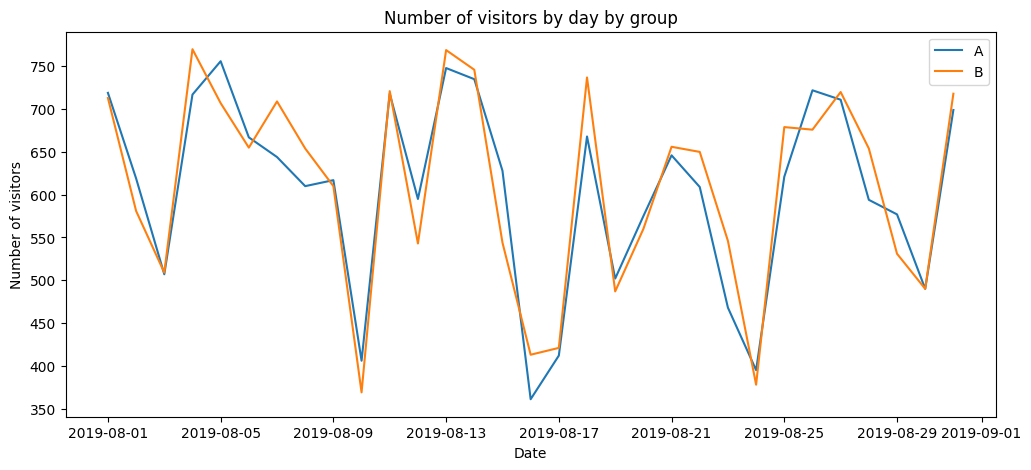

In [12]:
#build a graph with the dynamics of visitors by day by group.
fig = plt.figure()
fig.set_size_inches(12, 5)

visitorsGroupA = visitors.query('group == "A"')
visitorsGroupB = visitors.query('group == "B"')

# build a graph of the revenue of group A
plt.plot(visitorsGroupA['date'], visitorsGroupA['visitors'], label='A')

# build a graph of the revenue of group B
plt.plot(visitorsGroupB['date'], visitorsGroupB['visitors'], label='B')

plt.title('Number of visitors by day by group')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of visitors")
plt.show()

The number of site visitors by groups is approximately the same with very similar trends.

In [13]:
# create an array of unique pairs of date values and test groups
datesGroups = orders[['date','group']].drop_duplicates() 

In [14]:
# aggregate cumulative data on orders by day
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# aggregated cumulative data by day on online store visitors
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# combine cumulative data in one table and assign understandable names to its columns
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


In [15]:
#check that we have the same test start and end dates in the cumulativeData dataframe
print('Дата начала теста в объединенной таблице:', cumulativeData['date'].min())
print('Дата окончания теста в объединенной таблице:',cumulativeData['date'].max())

Дата начала теста в объединенной таблице: 2019-08-01 00:00:00
Дата окончания теста в объединенной таблице: 2019-08-31 00:00:00


### Graph of cumulative revenue by groups.

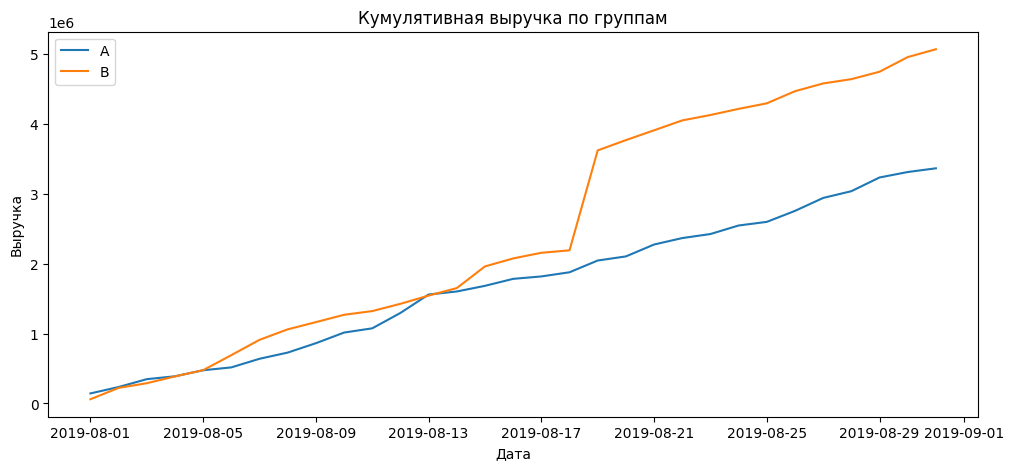

In [16]:
# dataframe with cumulative number of orders and cumulative revenue by day in group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# dataframe with cumulative number of orders and cumulative revenue by day in group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

fig = plt.figure()
fig.set_size_inches(12, 5)

# build a graph of the revenue of group A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# build a graph of the revenue of group B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.title('Кумулятивная выручка по группам')
plt.show()

**Conclusions**

At the beginning, group B and A did not differ much in terms of revenue, however, from a certain date, group B has consistently outperformed group A in terms of revenue and leads by a significant margin.
However, Group B's revenue curve rises sharply at one point. This may signal spikes in the number of orders, or the appearance of very expensive orders in the sample.

### Graph of the cumulative average bill by groups.

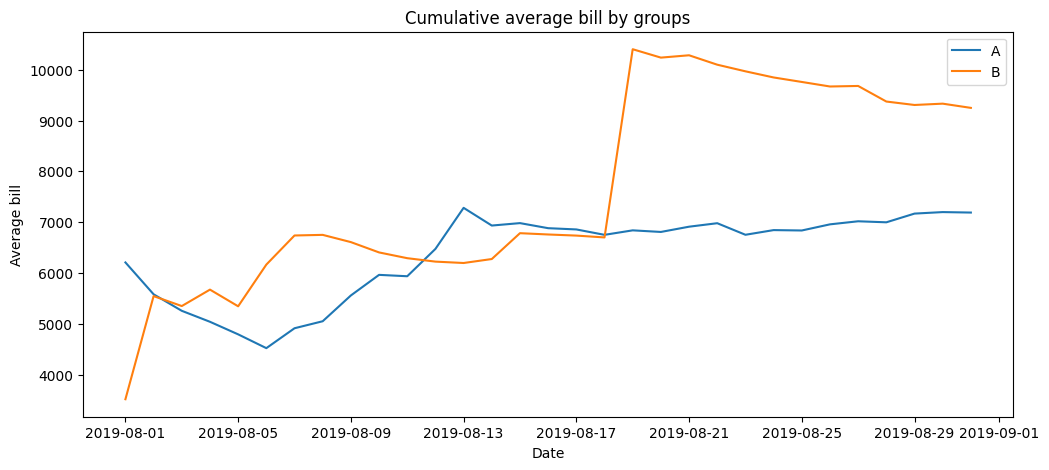

In [17]:
### build graphs of the average check by groups - we will divide the cumulative revenue by the cumulative number of orders:
fig = plt.figure()
fig.set_size_inches(12, 5)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.xlabel("Date")
plt.ylabel("Average bill")
plt.title('Cumulative average bill by groups')
plt.show()

**Conclusions**

It can be seen how the average check of group B grows at one point, from 7 thousand to 10 thousand, the average check of group A also grows, but more smoothly.

Perhaps, large orders fell into group B in the second half of the test, or this is the effect of the hypothesis being tested.

### Graph of the relative change in the cumulative average check of group B to group A.

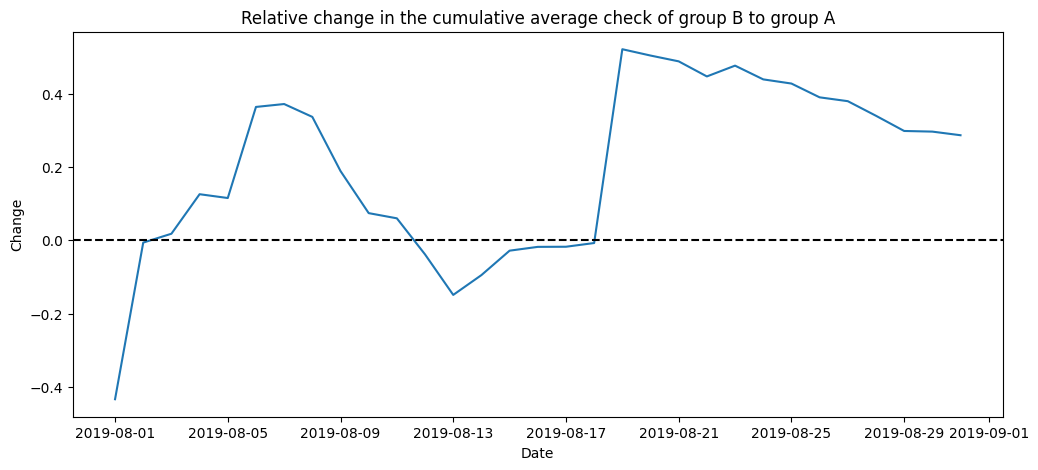

In [18]:
#plot the relative difference for the average bill.
# collect data in one dataframe
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


fig = plt.figure()
fig.set_size_inches(12, 5)

# build the ratio of average bills
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# add the X axis
plt.axhline(y=0, color='black', linestyle='--') 


plt.xlabel("Date")
plt.ylabel("Change")
plt.title('Relative change in the cumulative average check of group B to group A')
plt.show()

Group B has a cumulative average check about half the test higher than the average check of group A, except for the test period from about August 10 to August 18. The graph jumps sharply during this period, probably due to some kind of emissions.

### Graph of the cumulative average orders per visitor by group.

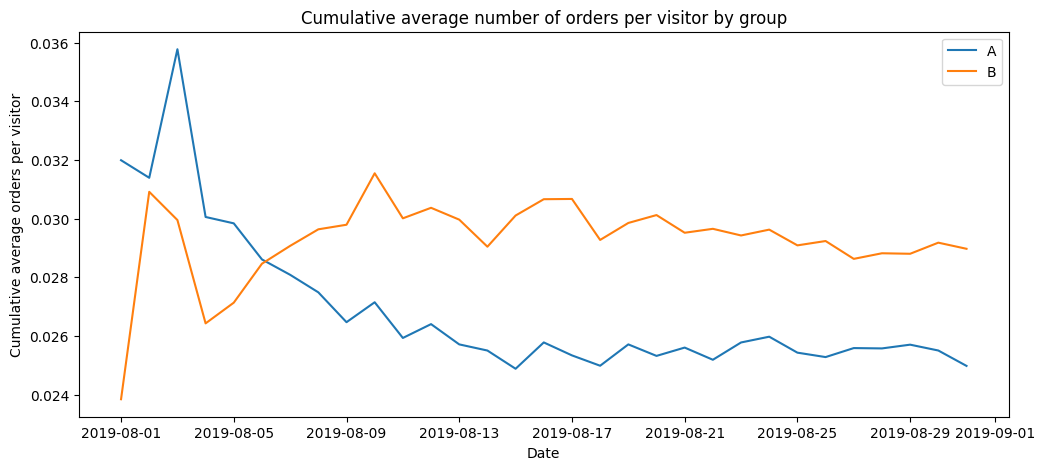

In [19]:
# calculate the cumulative conversion
cumulativeData['average_orders'] = cumulativeData['orders']/cumulativeData['visitors']

fig = plt.figure()
fig.set_size_inches(12, 5)

# separate data by group A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# separate data by group B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# plot graphs
plt.plot(cumulativeDataA['date'], cumulativeDataA['average_orders'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['average_orders'], label='B')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative average orders per visitor")
plt.title('Cumulative average number of orders per visitor by group')
plt.show()

**Conclusions**

Visitors in group B consistently make more orders than group A. This is probably the answer to the question of more revenue for group B.

### Graph of the relative change in the cumulative average number of orders per visitor of group B to group A.

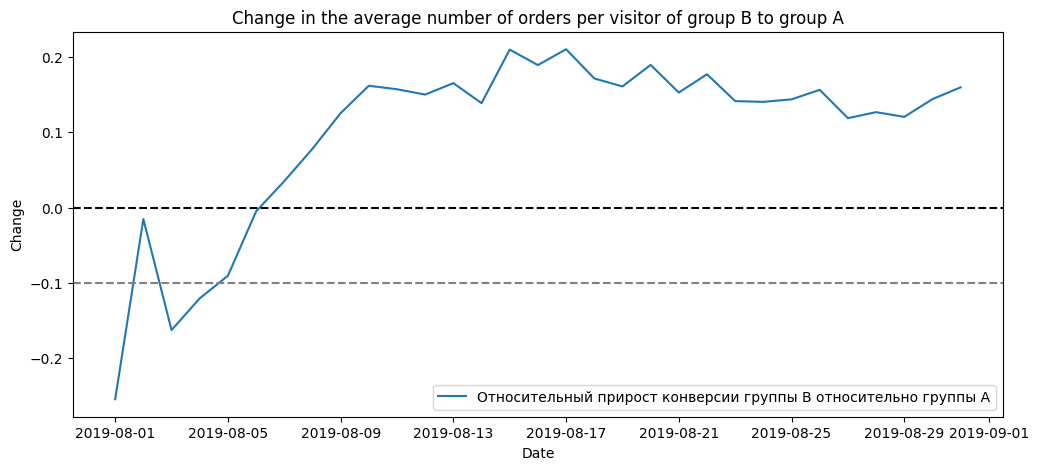

In [20]:
fig = plt.figure()
fig.set_size_inches(12, 5)

#plot the relative difference of cumulative conversions:
mergedCumulativeConversions = cumulativeDataA[['date','average_orders']].merge(cumulativeDataB[['date','average_orders']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['average_ordersB']/mergedCumulativeConversions['average_ordersA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Change")
plt.title('Change in the average number of orders per visitor of group B to group A')
plt.show()


This graph only emphasizes the previous one, in general, the ratio of the average number of orders is almost established.

### Scatter plot of the number of orders by user.

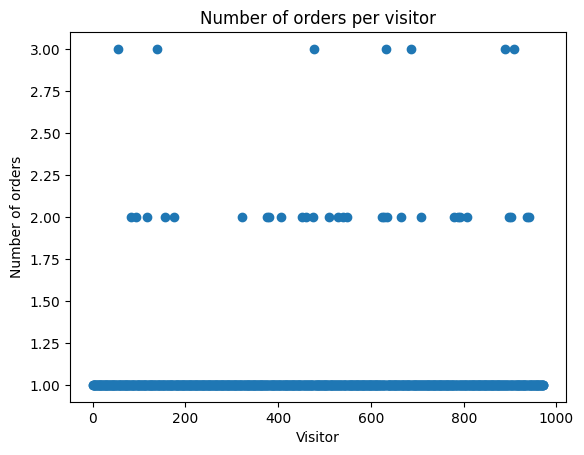

In [21]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique', 'revenue': 'sum'})
)

ordersByUsers.columns = ['userId', 'orders', 'revenue']

x_values = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel("Visitor")
plt.ylabel("Number of orders")
plt.title('Number of orders per visitor')
plt.show()

It can be seen that there are several users with more than 2 orders, but there are few of them. Mostly visitors have 1 and 2 orders. Let's build a histogram of the distribution of the number of orders for clarity

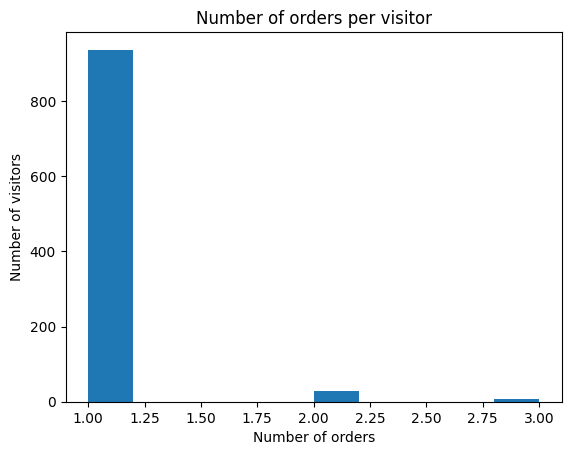

In [22]:
plt.hist(ordersByUsers['orders']) 
plt.xlabel("Number of orders")
plt.ylabel("Number of visitors")
plt.title('Number of orders per visitor')
plt.show()

The number of orders greater than 2 looks like abnormal outliers, check with the 95th and 99th percentiles.

### Selecting a border to identify anomalous users.

Let's calculate the 95th and 99th percentiles of orders per user.

In [23]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


**Conclusion:**
No more than 5% of visitors make more than 1 order and no more than 1% more than 2.

### Dot plot of order values.

To determine possible anomalous emissions by the cost of orders, we will build two graphs.

In [24]:
#calculate the amount of orders per user
avgOrderByUser = orders.groupby('visitorId').agg({'revenue': 'sum'})
avgOrderByUser.head()

,revenue
visitorId,
5114589,570
6958315,1490
11685486,6201
39475350,3990
47206413,730


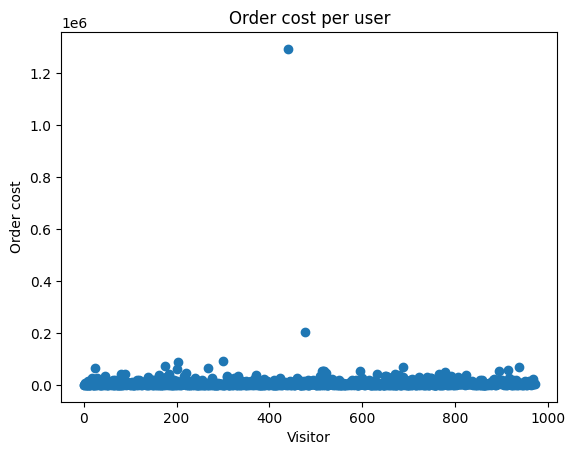

In [25]:
x_values = pd.Series(range(0,len(avgOrderByUser['revenue'])))
plt.scatter(x_values, avgOrderByUser['revenue'])
plt.xlabel("Visitor")
plt.ylabel("Order cost")
plt.title('Order cost per user')
plt.show()

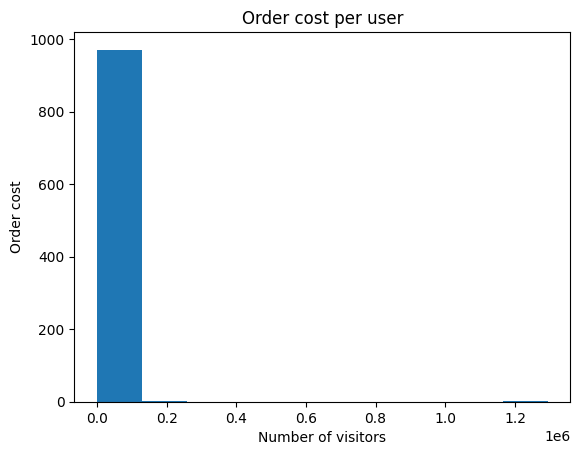

In [26]:
plt.hist(avgOrderByUser['revenue']) 
plt.xlabel("Number of visitors")
plt.ylabel("Order cost")
plt.title('Order cost per user')
plt.show()

The data clearly contains abnormally expensive orders (more than 1.2 million rubles), which shift the average bill. To accurately determine which data to cut off and check for "clean" data, we calculate the 95th and 99th percentiles for the cost of orders.

### Selecting a border to detect anomalous orders.
Let's calculate the 95th and 99th percentiles of order value.

In [27]:
print(np.percentile(avgOrderByUser['revenue'], [95, 99]))

[28910. 59082.]


No more than 5% of orders are more expensive than 29 thousand rubles and no more than 1% are more expensive than 59 thousand rubles.

### Statistical significance of differences in the average number of orders per visitor between groups on raw data.

In [28]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 



ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 



pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')


[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]



sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)



        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

Now that we have collected the data, let's check if there is a statistical significance of differences in the average number of orders per visitor between groups according to the "raw" data.
Thus, the null hypothesis: there is no difference in the average number of orders between groups. Alternative: there are differences in the average between groups.


Let's apply the Mann-Whitney test and format the p-value by rounding it to three decimal places.
The second value will display the relative increase in the average number of orders from group B to group A.

In [29]:
print('P-value: ', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Number of orders from group B / A : ', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value:  0.011
Number of orders from group B / A :  0.160


**Conclusion:** According to the "raw" data, there are differences in the average number of orders for groups A and B. The first number - p-value = 0.017 is less than 0.05. Hence, we reject the null hypothesis that there are no statistically significant differences in the average number of orders between groups.
The relative increase in the average number of orders in group B is 16% - the second number in the output.

This conclusion must be checked on "pure" data, and then it will be possible to say that in group B the number of orders is statistically significantly higher on average.

### Statistical significance of differences in the average order receipt between groups according to "raw" data.

Now let's check the statistical significance of differences in the average check between segments.
Null hypothesis: there are no differences in the average check between groups.
Alternative hypothesis: there are differences in the average bill between groups.

In [30]:
print('P-value: ', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('The ratio of the average bill in the group B / A : ','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value:  0.829
The ratio of the average bill in the group B / A :  0.287


P-value is significantly greater than 0.05. This means that there is no reason to reject the null hypothesis and believe that there are differences in the average bill.

Although the average check in group B is on average ~29% higher than in group A. Since the differences are not statistically significant, it means that they were obtained by chance.

### Statistical significance of differences in the average number of orders per visitor between groups on "cleaned" data.

We will take as abnormal users, those that do not fit into the 99 percentiles of users in terms of the number of orders - usersWithManyOrders and in terms of order value - usersWithExpensiveOrders. Let's combine them in the abnormalUsers table.

In [31]:
abnormalNumOrders = np.percentile(ordersByUsers['orders'], [99])
abnormalSumOrders = np.percentile(avgOrderByUser['revenue'], [99])

In [32]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > abnormalNumOrders[0]]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > abnormalNumOrders[0]]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > abnormalSumOrders[0]]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Let's calculate the statistical significance of the differences in the average number of orders between test groups according to the cleaned data. Let's apply the Mann-Whitney statistical test to the obtained samples:

In [33]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.006
0.191


The results for the average number of orders remained virtually unchanged. We reject the null hypothesis that there are no statistically significant differences in the average number of orders between groups. We accept an alternative hypothesis - there are static significant differences in the data and in group B the average number of orders is higher.

The relative increase in the average number of orders in group B is ~19% - the second number in the output.

### Statistical significance of differences in the average check of an order between groups according to "cleaned" data.

Checking if the test results for the average check have changed?

In [34]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.827
-0.017


P-value decreased, but the difference between segments decreased from 29% to 0%. All differences between segments in the average order receipt were based on outliers in Group B.

Although the general conclusions of the test results have not changed.

### Making a decision based on test results

Available facts:

- There is a statistically significant difference in the average number of orders between groups, both in raw and after filtering out anomalies. In group B, the average number of orders per visitor is statistically significantly higher.
- There is no statistically significant difference in the average check between groups, neither in the raw data nor in the data after filtering out the anomalies.
- The graph of the difference in the average number of orders between groups in section 3.5 highlights that the results of group B are better than group A and the data has stabilized.
- Average order difference plot shows that group B performs better than group A, however excluding abnormal visitors from both groups, the data shows that there is no difference in average order order between segments.

Based on the facts found, the test should be stopped and considered a success.
Group B brings in more orders on average than Group A.
At the same time, there were no differences in the average check between the groups.
Using the hypothesis in the application for group B, you can increase the revenue of the online store.